In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
# Acquire, load, and preview the data.
fbi = pd.read_csv('Data/fbi_after.csv')
fbi = fbi.drop(['Unnamed: 0'], axis=1)
display(fbi.head())

,Population,Murder,Robbery,Property crime,Population_sq
0,1861,0,0,12,3463321
1,2577,0,0,24,6640929
2,2846,0,0,16,8099716
3,97956,1,1,4090,9595377936
4,6388,0,1,223,40806544


In [3]:
from scipy import stats
fbi = fbi[(np.abs(stats.zscore(fbi)) < 3).all(axis=1)]

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)



Coefficients: 
 [[1.29510871e-02 1.14920528e-07 1.95038666e+02 9.28205845e+01]]

Intercept: 
 [-16.81586632]

R-squared:
0.8444937611173491


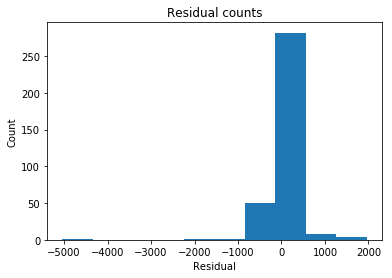

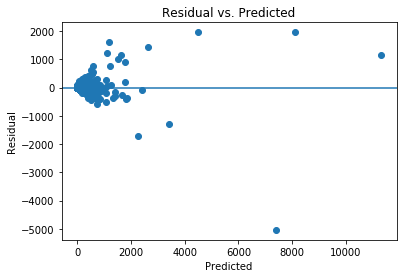

In [4]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = fbi['Property crime'].values.reshape(-1, 1)
X = fbi[['Population','Population_sq','Murder','Robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = fbi['Property crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

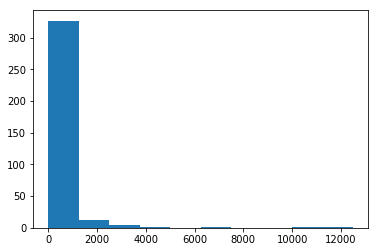

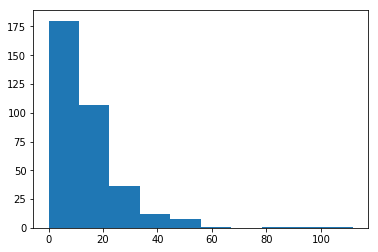

In [5]:
plt.hist(fbi['Property crime'])
plt.show()
fbi['Property crime_sqrt'] = np.sqrt(fbi['Property crime'])
plt.hist(fbi['Property crime_sqrt'])
plt.show()

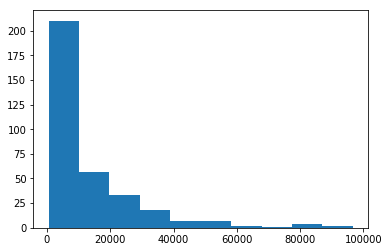

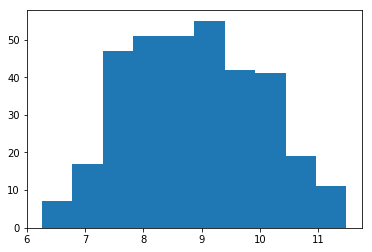

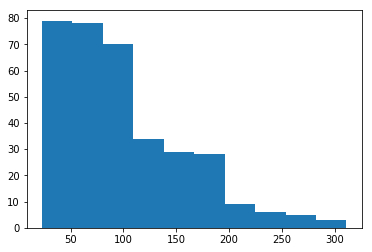

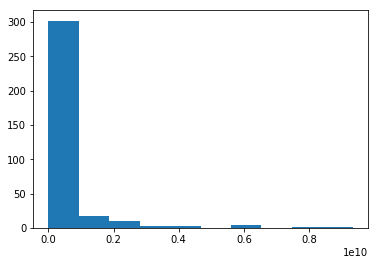

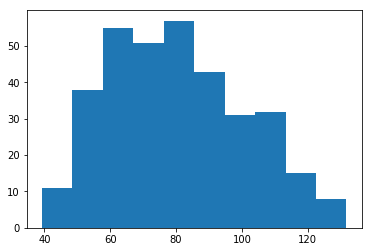

In [7]:
plt.hist(fbi['Population'])
plt.show()
fbi['Population_log'] = np.log(fbi['Population'])
plt.hist(fbi['Population_log'])
plt.show()
fbi['Population_sqrt'] = np.sqrt(fbi['Population'])
plt.hist(fbi['Population_sqrt'])
plt.show()
fbi['Population_sq'] = np.square(fbi['Population'])
plt.hist(fbi['Population_sq'])
plt.show()
fbi['Population_logsq'] = np.square(np.log(fbi['Population']))
plt.hist(fbi['Population_logsq'])
plt.show()

In [8]:
from scipy import stats
fbi = fbi[(np.abs(stats.zscore(fbi)) < 3).all(axis=1)]


Coefficients: 
 [[4.56978946e-02 2.06675736e-04 9.18230622e-01 4.28663558e+00
  2.30762613e+00]]

Intercept: 
 [-5.10793152]

R-squared:
0.7704116490362856


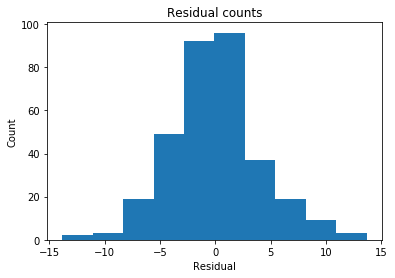

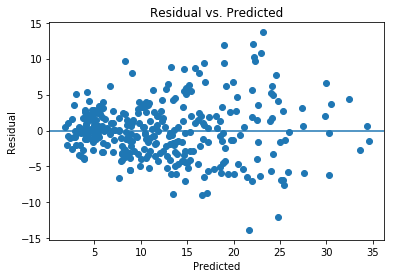

In [9]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = fbi['Property crime_sqrt'].values.reshape(-1, 1)
X = fbi[['Population_sqrt','Population','Population_log','Robbery','Murder']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = fbi['Property crime_sqrt']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [12]:
correlation_matrix = X.corr()
display(correlation_matrix)

,Population,Population_sq,Population_logsq,Robbery,Murder
Population,1.000,0.938,0.908,0.486,0.465
Population_sq,0.938,1.000,0.733,0.358,0.471
Population_logsq,0.908,0.733,1.000,0.587,0.401
Robbery,0.486,0.358,0.587,1.000,0.275
Murder,0.465,0.471,0.401,0.275,1.000


## Feature Engineering

Exploring the data I didn't want to over expose the model to features. Some features gave the model ease of prediction. Here is the list of features and explanation of how it fits in the model.

1. $\sqrt{Property Crime}$: This may have a been one that will transform the equation significantly but the feature helped in finding outliers and normalizing the residuals. Making the model better and more predictive.

2. $log(Population)$: This feature helped again normailize the population data to make it more suitable for the model. We also kept the normal Population data for a comparable model.

3. $\sqrt{Population}$: This feature was a standard feature. After more analysis it was added due to the transformation of the dependant variable.

The biggest feature of the model is the $\sqrt{Property Crime}$. This feature will change how the model is read and how the other features interact with it. Further details are to be explained in the final analysis.

# Model Analysis

Our predictive model of Property Crime:

$$\sqrt{Property Crime} = -0.59 + 0.062\sqrt{Population} + 0.00022Population + 0.22log(Population) + 4.21Murder + 3.04Robbery$$

With the dependent variable feature we will adjust the equation to read more clearly by squaring both sides. Resulting in the following:

$$Property Crime = -0.35 + 0.0038Population + 0.00022Population^2 + 0.048log(Population)^2 + 17.72Murder + 9.24Robbery$$

Now we can clearly see how big a an influence Murder and Robbery are to property crim rates. By simply having a robbery or murder in the area there is an increase in  property crimes by 9 to 17 instances, repectively. Another thing to note is how the population does not impact property crime as much as it may seem. But when you are considering populations in bigger cities grow by the thousands this factor has significant impact. For instance, in the city of denver the population is currently growing by nearly 20%. This means that since 2010 until now the population grew by nearly 120,000. Applying our model, this would mean property crime has risen by 456 instances in the past few years. 

Now these results are certaintly not final, as there may be some correlations of population with some of the other variables (Murder & Robbery). Also, by having the Murder and Robbery variables as categorical and not continuous may change the resuls of the model. It may also give clearer results that apply more accurately. All of this analysis and modelling still cannot give us an answer to solve the issues of property crime. This analysis only tell us what is happenning in the area and what factors impact those occurences. 